# Import and misc

In [ ]:
# Instal latest torch and torchaudio

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses
import wandb

import numpy as np
import pandas as pd

import os
import random
import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

import tempfile
from thop import profile
from thop import clever_format
import copy
import wandb


# Import models
from models.blocks  import *
from models.crnn_base import *
from models.crnn_ds_small import *
from models.crnn_base_streaming import *


# Import functions from seminar
from src.dataset import *
from src.utils import *
from src.trainer import  *
from src.eval import *

# Part 0.
## Reproduce base model and set everything up

In [2]:
def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
SEED = 42

seed_everything(SEED)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 4e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    temperature:int =  20
    alpha:float = 0.6
    gamma:float = 0.01
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

### Data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 22:02:03--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.145.128, 2a00:1450:4013:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.145.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   114MB/s    in 15s     

2022-11-06 22:02:18 (94.8 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [4]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

### Train/val split

In [5]:
indexes = pd.Series(np.arange(len(dataset))).sample(frac=1, random_state=SEED, replace=False).values
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [6]:
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

In [7]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [8]:
# num_workers = 0 for mac
train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Reproduce base model

In [9]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

In [10]:
config = TaskConfig(hidden_size=32, num_epochs=20)
model = CRNN(config).to(config.device)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)


In [ ]:
#TRAIN uncomment to reproduce base model


# history = defaultdict(list)
# for n in range(config.num_epochs):

#     train_epoch(model, opt, train_loader,
#                 melspec_train, config.device)

#     au_fa_fr = validation(model, val_loader,
#                           melspec_val, config.device)
#     history['val_metric'].append(au_fa_fr)

#     clear_output()
#     plt.plot(history['val_metric'])
#     plt.ylabel('Metric')
#     plt.xlabel('Epoch')
#     plt.grid()
#     plt.show()

#     print('END OF EPOCH', n)

In [11]:
model.load_state_dict(torch.load('checkpoints/model_base.pth', map_location=torch.device(config.device)))
validation(model, val_loader,
                          melspec_val, config.device)

102it [00:21,  4.74it/s]


3.129978706298344e-05

# Part 1.
## Distill

utils для подсчета метрик

In [12]:
def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

def calc_rates(base_model, candidate_model):
    base_model = copy.deepcopy(base_model)
    candidate_model = copy.deepcopy(candidate_model)
    
    sample = torch.randn(1, 40, 101).to('cpu')

    BASE_WEIGHT = get_size_in_megabytes(base_model)
    BASE_FLOPS = profile(base_model.to('cpu'), (sample,))[0]

    model_weight = get_size_in_megabytes(candidate_model)
    model_flops = model_flops = profile(student_model.to('cpu'), (sample,))[0]

    return f'Compression_rate: {BASE_WEIGHT/model_weight :.3f}, Speedup rate: {BASE_FLOPS / model_flops :.3f}'

Создадим классы для создания обучаемых отображений из слоев учителя в слои ученика

In [13]:
class Projector(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.out_shape = out_shape
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_shape[0]*in_shape[1],in_shape[0]*in_shape[1])
        self.out = nn.Linear(in_shape[0]*in_shape[1],out_shape[0]*out_shape[1])

    def forward(self, x):
        x = x.flatten()
        x = self.relu(self.fc(x))
        x = self.out(x)
        return x.view(self.out_shape)

class LinearProjector(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.out_shape = out_shape
        self.out = nn.Linear(in_shape[0]*in_shape[1],out_shape[0]*out_shape[1])

    def forward(self, x):
        x = x.flatten()
        x = self.out(x)
        return x.view(self.out_shape)

Будем использовать 3 лосса для дистилляции - жесткие таргеты, мягкие таргеты (ответы модели-учителя) и mse между слоями (отображением слоя большой модели и слоем маленькой). Для получения отображений попробуем 3 варианта - mean/max pool, линейный слой и двухслойная сетка.

In [14]:
def distill_loss( var_X_batch, var_y_batch, teacher_model,student_model, temperature, alpha,gamma, projectors=None):
    kldloss = nn.KLDivLoss(reduction="batchmean")  
    celoss = nn.CrossEntropyLoss()

    with torch.no_grad():
        teacher_logits = teacher_model(var_X_batch)
    student_logits = student_model(var_X_batch)
    
    soft_predictions = F.log_softmax( student_logits / temperature, dim=1 )
    soft_labels = F.softmax( teacher_logits / temperature, dim=1 )
    out_loss = kldloss(soft_predictions, soft_labels)


    rnn_loss = 0
    attention_loss = 0
    if gamma  > 0:
        if projectors:

            teacher_model_gru_w1 = projectors[0](teacher_model.gru.weight_hh_l0.detach())
            teacher_model_gru_w2 = projectors[1](teacher_model.gru.weight_ih_l0.detach())
            att_h1 = projectors[2](teacher_model.attention.energy[0].weight.detach())
            att_h2 = projectors[3](teacher_model.attention.energy[2].weight.detach())
        else:
            pooling1 = nn.AvgPool2d(kernel_size=4)
            teacher_model_gru_w1 = pooling1(teacher_model.gru.weight_hh_l0.detach().unsqueeze(0)).squeeze(0)

            pooling2 = nn.AvgPool2d(kernel_size=(4,1))
            teacher_model_gru_w2 = pooling2(teacher_model.gru.weight_ih_l0.detach().unsqueeze(0)).squeeze(0)

            pooling3 = nn.MaxPool2d(kernel_size=(4,4))
            att_h1 = pooling3(teacher_model.attention.energy[0].weight.detach().unsqueeze(0)).squeeze(0)
            pooling4 = nn.MaxPool2d(kernel_size=(1,4))
            att_h2 = pooling4(teacher_model.attention.energy[2].weight.detach().unsqueeze(0)).squeeze(0)

        attention_loss += nn.functional.mse_loss(student_model.attention.energy[0].weight.detach(), att_h1)
        attention_loss += nn.functional.mse_loss(student_model.attention.energy[2].weight.detach(), att_h2)
        rnn_loss += nn.functional.mse_loss(student_model.gru.weight_hh_l0.detach(), teacher_model_gru_w1)
        rnn_loss += nn.functional.mse_loss(student_model.gru.weight_ih_l0.detach(), teacher_model_gru_w2)

    student_loss = celoss(student_logits, var_y_batch)
    
    return out_loss * alpha + student_loss * (1 - alpha) + gamma*(rnn_loss + attention_loss), student_logits
    



In [15]:
def distill_epoch(student_model, teacher_model, opt, loader, log_melspec, device,temperature,alpha,gamma, projectors=None):
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()
        loss, logits = distill_loss(batch, labels,  teacher_model,student_model, temperature, alpha, gamma,projectors)
        probs = F.softmax(logits, dim=-1)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

def distill(student_model, teacher_model, opt, train_loader, val_loader, melspec_train, melspec_val, config, projectors=None ):
    
    wandb.init(project="kws_project",
               config=config)

    teacher_model.eval()
    bst_model = student_model
    bst_score = 1
    for n in range(config.num_epochs):
        student_model.train()

        distill_epoch(student_model, teacher_model, opt, train_loader,
                    melspec_train, config.device, config.temperature, config.alpha, config.gamma, projectors)

        au_fa_fr = validation(student_model, val_loader,
                            melspec_val, config.device)
        
        wandb.log({'epoch':n, 'val_netric':au_fa_fr})
        history['val_metric'].append(au_fa_fr)
        if au_fa_fr < bst_score:
            bst_score = au_fa_fr
            bst_model = copy.deepcopy(student_model)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)

    return bst_model

### Layerwise дистилляция c линейными отображениями слоев (ds 8x1x10)

Используем линейный слой чтобы смэтчить размерности скрытых слоев rnn / attention у студента и учителя. Далее  считаем MSE между получившимися отображениями и добавляем его к лоссу с весом `gamma`.

In [18]:


micro_config = TaskConfig(
    hidden_size=10,
    cnn_out_channels=8,
    gru_num_layers=1,
    num_epochs=25,
    temperature=10,
    learning_rate=5e-5,
    alpha=0.2,
    gamma=0.2,
    batch_size=512
    )

projector_rnn_1 = LinearProjector([96, 32], [micro_config.hidden_size*3, micro_config.hidden_size])
projector_rnn_2 = LinearProjector([96, 144], [micro_config.hidden_size*3, 144])
projector_att_1 = LinearProjector([32, 32],[micro_config.hidden_size, micro_config.hidden_size] )
projector_att_2 = LinearProjector([1, 32], [1, micro_config.hidden_size])
projectors = [projector_rnn_1, projector_rnn_2, projector_att_1, projector_att_2]
projectors  = [p.to(micro_config.device) for p in projectors]

student_model = CRNNmicro(micro_config).to(micro_config.device)
base_config = TaskConfig(hidden_size=32)
teacher_model = CRNN(base_config).to(base_config.device)
teacher_model.load_state_dict(torch.load('checkpoints/model_base.pth', map_location=torch.device('cpu')))

params  = list(student_model.parameters()) +\
          list(projector_rnn_1.parameters()) +\
          list(projector_rnn_2.parameters()) +\
          list(projector_att_1.parameters()) +\
          list(projector_att_2.parameters())

optimizer = torch.optim.Adam(params,
                             lr=micro_config.learning_rate,
                             weight_decay=micro_config.weight_decay)

melspec = LogMelspec(is_train=False, config=micro_config)
history = defaultdict(list)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
# student_model = distill(student_model, teacher_model, optimizer,
#                         train_loader, val_loader, melspec, melspec, micro_config, projectors )

In [22]:
student_model.load_state_dict(torch.load('checkpoints/complex_distill1_tuned.pth').state_dict())
student_model = student_model.train()

In [134]:
validation(student_model, val_loader,
                          melspec_val, micro_config.device)

102it [00:06, 16.82it/s]


5.173266998074422e-05

In [135]:
calc_rates(teacher_model, student_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


'Compression_rate: 4.404, Speedup rate: 5.779'

In [136]:
torch.save(student_model, 'checkpoints/final_model.pth')

### Layerwise дистилляция c нелинейным отображениями слоев (ds 8x1x10)

Используем сетку с 2 линейными слоями чтобы смэтчить размерности скрытых слоев rnn / attention у студента и учителя. Далее  считаем MSE между получившимися отображениями и добавляем его к лоссу с весом `gamma`.

In [ ]:
micro_config = TaskConfig(
    hidden_size=10,
    cnn_out_channels=8,
    gru_num_layers=1,
    num_epochs=25,
    temperature=10,
    learning_rate=3e-4,
    alpha=0.2,
    gamma=0.2,
    batch_size=512
    )

projector_rnn_1 = Projector([96, 32], [micro_config.hidden_size*3, micro_config.hidden_size])
projector_rnn_2 = Projector([96, 144], [micro_config.hidden_size*3, 144])
projector_att_1 = Projector([32, 32],[micro_config.hidden_size, micro_config.hidden_size] )
projector_att_2 = Projector([1, 32], [1, micro_config.hidden_size])
projectors = [projector_rnn_1, projector_rnn_2, projector_att_1, projector_att_2]
projectors  = [p.to(micro_config.device) for p in projectors]

student_model = CRNNmicro(micro_config).to(micro_config.device)
base_config = TaskConfig(hidden_size=32)
teacher_model = CRNN(base_config).to(base_config.device)
teacher_model.load_state_dict(torch.load('checkpoints/model_base.pth', map_location=torch.device('cpu')))

params  = list(student_model.parameters()) +\
          list(projector_rnn_1.parameters()) +\
          list(projector_rnn_2.parameters()) +\
          list(projector_att_1.parameters()) +\
          list(projector_att_2.parameters())

optimizer = torch.optim.Adam(params,
                             lr=micro_config.learning_rate,
                             weight_decay=micro_config.weight_decay)

melspec = LogMelspec(is_train=False, config=micro_config)
history = defaultdict(list)

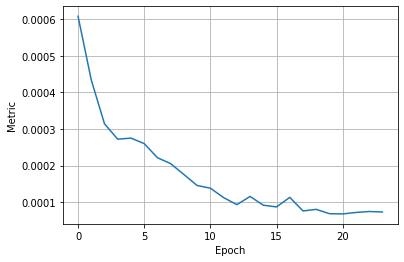

END OF EPOCH 23


 23%|██▎       | 92/405 [00:13<00:45,  6.88it/s]


KeyboardInterrupt: ignored

In [25]:
student_model = distill(student_model, teacher_model, optimizer,
                        train_loader, val_loader, melspec, melspec, micro_config, projectors )

### Костыльная layerwise дистилляция

Используем mean/max pooling чтобы смэтчить размерности скрытых слоев rnn / attention у студента и учителя. Далее  считаем MSE между получившимися отображениями и добавляем его к лоссу с весом `gamma`.

In [ ]:
micro_config = TaskConfig(
    hidden_size=8,
    cnn_out_channels=8,
    gru_num_layers=1,
    num_epochs=15,
    temperature=20,
    learning_rate=1e-4,
    alpha=0.7,
    gamma=0.05,
    batch_size=512
    )

student_model = CRNNmicro(micro_config).to(micro_config.device)
base_config = TaskConfig(hidden_size=32)
teacher_model = CRNN(base_config).to(base_config.device)
teacher_model.load_state_dict(torch.load('checkpoints/model_base.pth', map_location=torch.device('cpu')))

optimizer = torch.optim.Adam(student_model.parameters(),
                             lr=micro_config.learning_rate,
                             weight_decay=micro_config.weight_decay)

melspec = LogMelspec(is_train=False, config=micro_config)
history = defaultdict(list)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


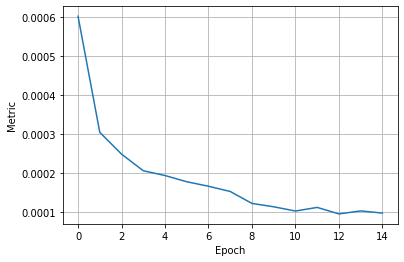

END OF EPOCH 14


In [ ]:
distill(student_model, teacher_model, optimizer, train_loader, val_loader, melspec, melspec, micro_config )

In [ ]:
validation(student_model, val_loader,
                          melspec_val, micro_config.device)

102it [00:06, 15.09it/s]


9.712780443033716e-05

### Дефолтная дистялляция (ds 8x1x16)

Добавляем KL дивергенцию выходов софтмакса учителя и студента в лосс с параметром `alpha` с учетом температуры `temperature`. Аугментации не используются.

In [ ]:
micro_config = TaskConfig(
    hidden_size=16,
    cnn_out_channels=8,
    gru_num_layers=1,
    num_epochs=15,
    temperature=10,
    learning_rate=3e-4,
    alpha=0.2,
    gamma=0,
    batch_size=512
    )

student_model = CRNNmicro(micro_config).to(micro_config.device)
base_config = TaskConfig(hidden_size=32)
teacher_model = CRNN(base_config).to(base_config.device)
teacher_model.load_state_dict(torch.load('checkpoints/model_base.pth', map_location=torch.device('cpu')))

optimizer = torch.optim.Adam(student_model.parameters(),
                             lr=micro_config.learning_rate,
                             weight_decay=micro_config.weight_decay)

melspec = LogMelspec(is_train=False, config=micro_config)
history = defaultdict(list)

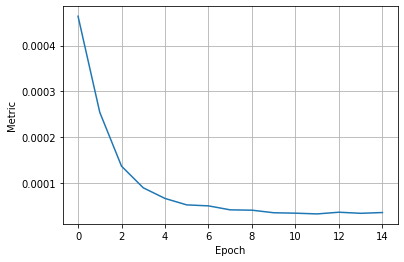

END OF EPOCH 14


In [ ]:
student_model =  distill(student_model, teacher_model, optimizer, train_loader, val_loader, melspec, melspec, micro_config )

In [ ]:
validation(student_model, val_loader,
                          melspec_val, micro_config.device)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:956: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
102it [00:05, 17.72it/s]


3.256490715018124e-05

In [ ]:
calc_rates(teacher_model, student_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


'Compression_rate: 2.852, Speedup rate: 3.892'

In [ ]:
torch.save(student_model, 'checkpoints/simple_distill.pth')

## Квантизация

Используем только динамическую квантизацию

In [119]:
test_config = TaskConfig(hidden_size=10,cnn_out_channels=8,gru_num_layers=1,device='cpu')
student_model = CRNNmicro(test_config).to(test_config.device)
student_model.load_state_dict(torch.load('/content/checkpoints/complex_distill1_tuned.pth').state_dict())

In [120]:
quantized_model = torch.quantization.quantize_dynamic(
    student_model.to("cpu"), {torch.nn.Linear, torch.nn.GRU}, dtype=torch.torch.qint8
)

In [121]:
melspec_test = LogMelspec(is_train=False, config=test_config)
validation(quantized_model.to('cpu'), val_loader,
                          melspec_test, test_config.device,)

102it [00:12,  8.13it/s]


5.6626058997264034e-05

In [122]:
calc_rates(teacher_model, quantized_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


'Compression_rate: 8.707, Speedup rate: 5.779'

# Part 2.
### Streaming

In [24]:
from models.crnn_ds_small_streaming import CRNNMicroStreaming

model_streaming = CRNNMicroStreaming(micro_config).to('cpu')
model_streaming.load_state_dict(torch.load('checkpoints/final_model.pth', map_location=torch.device('cpu')).state_dict())

In [25]:
sm = torch.jit.script(model_streaming)
sm.save("checkpoints/final_model_streaming.pt")

In [26]:
import matplotlib.pyplot as plt
def visualize_streaming(streaming_model, audio):
    streaming_model.eval()
    probs = []
    chunk_size = 8000
    audio_length = audio.size()[0]
    chunks = range(1,audio_length // chunk_size + 1 )

    for T in chunks:
        chunk = audio[(T-1)*chunk_size:T*chunk_size].view(1, -1)
        with torch.inference_mode():
            out = streaming_model(chunk)
        probs.append(out)

    plt.plot(chunks, probs)

Сделаем игрушечный пример из тишины и двух ключевых слов (первое из которых - таргет)

In [28]:
import IPython.display as ipd


streaming_model = torch.load('checkpoints/final_model_streaming.pt')
audio, labels =  next(iter(val_loader))
audio_sample = torch.Tensor(np.zeros(shape=2*16_000).tolist() + audio[labels.tolist().index(1)].tolist() + audio[0].numpy().tolist())
ipd.Audio(audio_sample.numpy(), rate=16_000)

Моделька неплохо отрабатывает - улавливает слово уже на его первом чанке (5 чанк на графике)

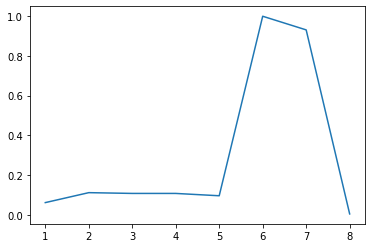

In [29]:
visualize_streaming(streaming_model, audio_sample)